# MAE6292 - Camera Calibration

Camera Calibration and Object Rendering

## Import Modules



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

## Google Colab

**Note**: skip this cell, if you are running it on your local computer.

If you are running this code in Google Colab, execute the following commands to load `cv2_imshow` and mount your Google Drive.

The last line assumes that the homework folder in your local computer is `Google Drive/MAE6292/HW2`. Modify it if yours is in a different folder.

In [2]:
# from google.colab.patches import cv2_imshow
# from google.colab import drive

# drive.mount('/content/drive')

# %cd drive/MyDrive/MAE6292/HW2

Make it sure you are in the correct folder.

In [3]:
!pwd
!ls

/Users/tylee/Google Drive/MAE6292/python_examples/calibration
IMG_0533.mov      calibration.ipynb data              video2frame.ipynb


## Jupyter Notebook

**Note**: skip this cell, if you are running this remotely on Google Colab.

It turns out that `cv2.imshow()` does not work in Jupter Notebook as well. You may use the follwing function `cv2_imshow` instead. 

In [4]:
def cv2_imshow(image):
# developed by Kanishke Gamagedara, udpated by MAE6292
    plt.figure(dpi=200)
    mode = len(np.shape(image))
    if mode==3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    elif mode==2:
        plt.imshow(image, cmap='gray')
    else:
        print('Unsuported image size')
        raise
    plt.xticks([]), plt.yticks([]) 
    plt.axis('off')

## Calibration with OpenCV

An image of chessboard is loaded.



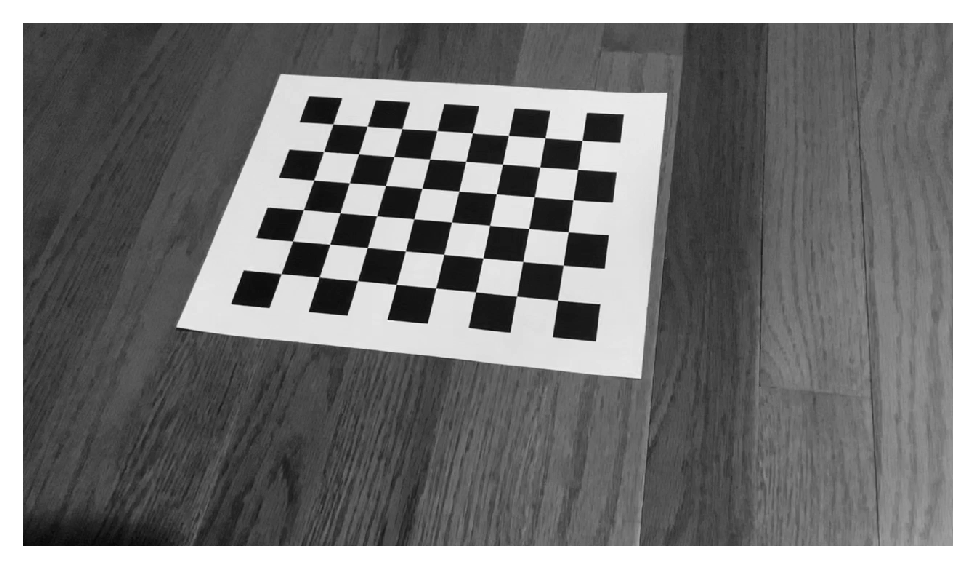

In [20]:
img = cv2.imread('data/frame0.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img_gray)

The checker size corresponds to the number of **INNER CORNERS**.
The pixel coordinates of those corners can be detected by [cv2.findChessboardCorners()](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a), and they are visualized by [cv2.drawChessboardCorners](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022)

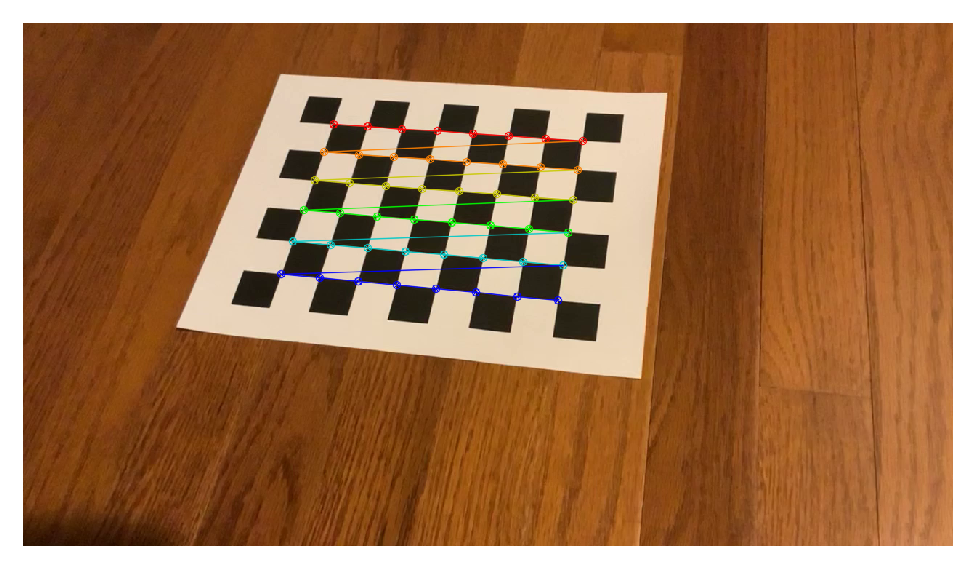

In [6]:
CHECKER = (8,6)
flag_found, corners = cv2.findChessboardCorners(img_gray, CHECKER)

# print(corners.shape)
# print(corners)

img_corner = img.copy()
cv2.drawChessboardCorners(img_corner, CHECKER, corners, flag_found)
cv2_imshow(img_corner) 

The detected pixel location of corners are refined by [cv2.cornerSubPix](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e)

(48, 1, 2)
float32


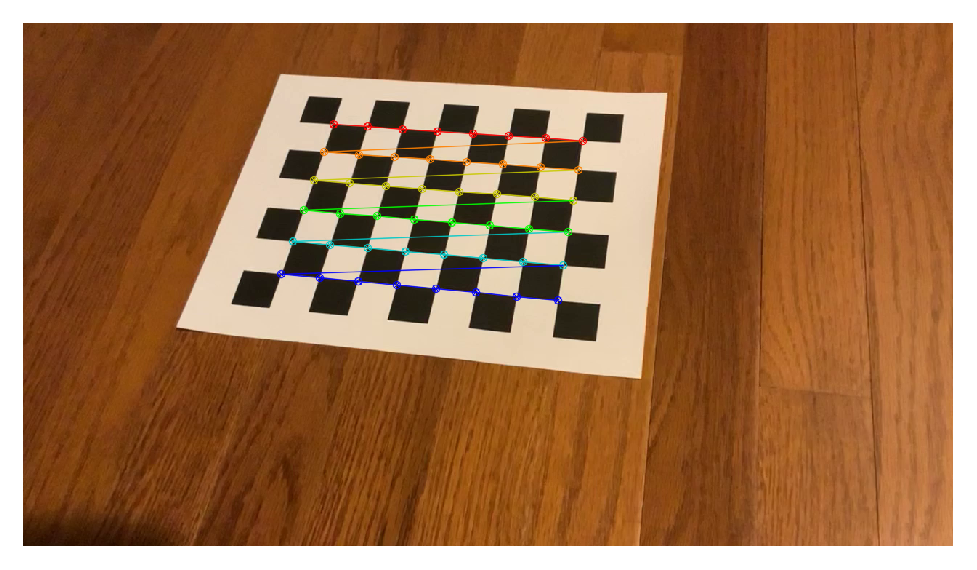

In [7]:
criteria_subpix = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
corners_refined = cv2.cornerSubPix(img_gray, corners, (11,11), (-1,-1), criteria_subpix)

print(corners_refined.shape)
print(corners_refined.dtype)
#print(corners_refined)

img_corner = img.copy()

cv2.drawChessboardCorners(img_corner, CHECKER, corners, flag_found)
cv2_imshow(img_corner) 

What are those colored dots and lines? They represent the order that the detected corners are saved in the variarble `corners`.

To calibrate the camera, we have to provide the coordinates of those corners in the world frame, according to the order illustrated by the color.

But defining those coordinates are not difficult, as all of the corners lie in a 2D plane. Let the origin of the world frame be at the first corner. The $x$-axis is pointing toward the second corner, and the $y$-axis is pointing down toward the first oranage corner. According to the right-hand rule, the $z$ axis will be pointing into the floor.

Then, the first corner is `[[0,0,0]]` (Note: it is `1x3 np.array`), and the second corner is `[[1,0,0]]` times the actual size of the square, which is `25 mm = 0.025 m`

Now, we have to define a container that stores the actual 3D coordinates of corners represented by `1x3 np.array`, according to the same order as those are detected. For example, `checker_width*[ [[0,0,0]], [[1,0,0]], [[2,0,0]], ..., [[7,0,0]], [[0,1,0]], ... , [[7,5,0]] ]`. 
Also, the data type ** must be `np.float32`**

In [33]:
# Creating vector to store vectors of 3D points for each checkerboard image
CHECKER_WIDTH = 0.025

obj_points = np.zeros( (CHECKER[0] * CHECKER[1], 1, 3 ), np.float32)
for i in range(CHECKER[1]):
    for j in range(CHECKER[0]):
         obj_points[i*CHECKER[0]+j,0,:]=np.array([[i,j,0]])
obj_points *= CHECKER_WIDTH
            
            
print(obj_points.shape)
print(obj_points.dtype)
# print(obj_points)


(48, 1, 3)
float32


Then, both of intrinsic and extrinsic parameters are obtained by [cv2.calibrateCamera](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d). Note the `obj_points` and `corners_refined` **must be nested in `[]`.**

This yields the calibration matrix $K$, and the distortion coefficients in the order of $k_1,k_2, p_1,p_2,k_3$. 
Further, the rotation matrix is given by `rvecs` in terms of the [Rodriguez paramter](https://mathworld.wolfram.com/RodriguesRotationFormula.html), and the translation vector is given by `tvecs`

Note: the distortion coefficients are normalized in some way, so they cannot be directly utilized in the formula in the note.

In [26]:
err, K, dist_coeff, rvecs, tvecs = cv2.calibrateCamera([obj_points], [corners_refined], img_gray.shape[::-1], None, None)

print(dist_coeff)
print(K)

R, _ = cv2.Rodrigues(rvecs[0])
T = tvecs[0]


print(R)
print(R@T)


[[ 3.54017139e-01 -1.69774183e+01  7.17601472e-03 -1.13803304e-02
   3.04080362e+02]]
[[1.29853237e+03 0.00000000e+00 6.02714584e+02]
 [0.00000000e+00 1.29350826e+03 3.14074131e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.18653667  0.97437767 -0.12566715]
 [ 0.82737734  0.08682902 -0.5548941 ]
 [-0.52976486 -0.20748225 -0.82237479]]
[[-0.15360745]
 [-0.45066809]
 [-0.48107177]]
[[-5.61520918e+02  1.14020836e+03 -6.58840148e+02  2.84761518e+02]
 [ 9.03833983e+02  4.71492417e+01 -9.76046753e+02  9.37507408e+01]
 [-5.29764864e-01 -2.07482254e-01 -8.22374795e-01  6.64997770e-01]]


Now we have both of the intrinsic paramter $K$ and the extrinsic paramter $(R,T)$, from which we can compute the projection matrix $M$. 

Using this any point in the 3D world frame can be projected to the image plane. Here we draw a line starting from the origin and pointing toward the $x$-axis, whose length is equal to the checker width.

[[0.    0.   ]
 [0.    0.025]
 [0.    0.   ]
 [1.    1.   ]]
[[284.76151814 313.26672707]
 [ 93.75074076  94.92947181]
 [  0.66499777   0.65981071]]
[[428.21424549 474.78272299]
 [140.97903039 143.87379578]]
[[428 474]
 [140 143]]


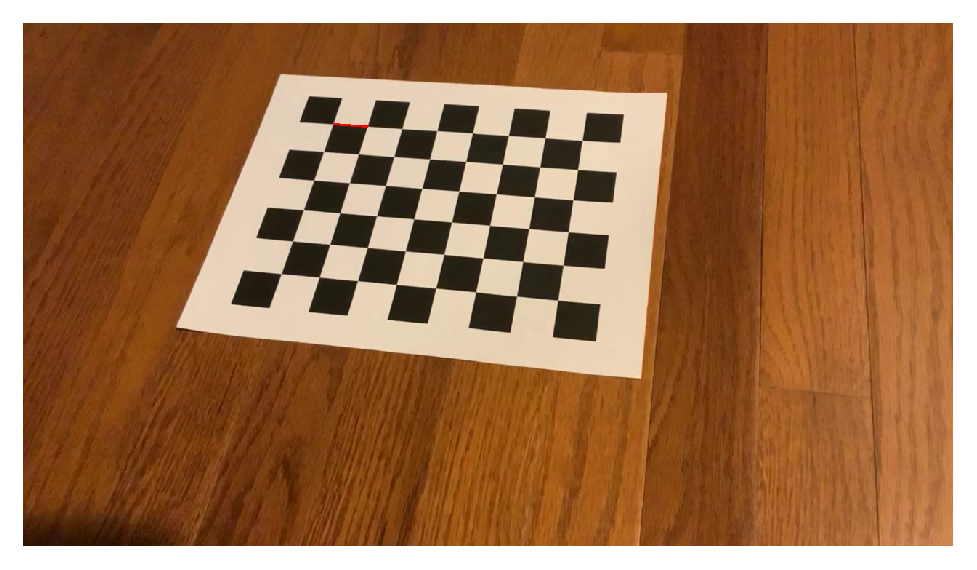

In [34]:
M = K @ np.concatenate( (R, T) , axis=1)


p_W = np.array([ [0,0,0,1], [0,CHECKER_WIDTH,0,1] ]).T 
print(p_W)
p_I = M @ p_W
print(p_I)
p_I = p_I[0:2,:]/p_I[2,:]
print(p_I)
p_I = p_I.astype(int)
print(p_I)

img_line = img.copy()

cv2.line(img_line, (p_I[0,0], p_I[1,0]), (p_I[0,1], p_I[1,1]), (0,0,255), 2)
cv2_imshow(img_line)